In [16]:
import numpy as np
import pandas as pd
from matplotlib import rc
rc('text', usetex=False)
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, time
import scipy
from scipy import signal
from sklearn.metrics import roc_curve, roc_auc_score
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-talk')
plt.style.use('seaborn-pastel')
import iminuit
import probfit

In [34]:
def truncate_tails(hist, nsigma=4):
    # Removes feature outliers above nsigma stddevs away from mean
    hist = hist[hist > np.mean(hist)-nsigma*np.std(hist)]
    hist = hist[hist < np.mean(hist)+nsigma*np.std(hist)]
    return hist

def compare_histograms_overlay(data_sig, data_bkg, nbins=50, columns=None, norm=True, data_bkg2=None, data_bkg3=None, weights_bkg=None, 
                               weights_bkg2=None, weights_bkg3=None, weights_signal=None, name='plot', MC=True, xlabel=None, 
                               binwidth=None, save=False, xlim=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    crimson_tide = '#e50005'
    yellow = 'xkcd:crimson'
    orange = '#ffa500'
    titles={'B_Mbc': r'$M_{bc}$ (GeV)', 'B_deltaE': r'$\Delta E$ (GeV)', 'B_hadronic_mass': r'$M_{X_q}$ (GeV)'}
    for i, variable in enumerate(columns):      
#         d_sig = truncate_tails(data_sig[variable].values,5)
#         d_bkg = truncate_tails(data_bkg[variable].values,5)
        d_sig = data_sig[variable] #truncate_tails(data_sig[variable].values,4)
        d_bkg = data_bkg[variable] #truncate_tails(data_bkg[variable].values,4)
        
#         if xlim is not None:
#             plt.xlim(xlim[0], xlim[1])
            
        if MC is True:   
            sns.distplot(d_bkg, color = steel_blue, hist=True, kde=False, norm_hist=norm, label='Background',bins=nbins,
                 hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.65, weights=weights_bkg))
            if isinstance(data_bkg2, pd.DataFrame):
                d_bkg2 = data_bkg2[variable]  # truncate_tails(data_bkg2[variable].values,5)
                sns.distplot(d_bkg2, hist=True, kde=False, norm_hist=norm, label = r'$\Upsilon(4S) \rightarrow B\bar{B}$',bins=nbins,
                     hist_kws=dict(edgecolor="0.85", color=crimson_tide,linewidth=0.5, alpha = 0.55, weights=weights_bkg2))
            if isinstance(data_bkg3, pd.DataFrame):
                d_bkg3 = truncate_tails(data_bkg3[variable].values,5)
                sns.distplot(d_bkg3, hist=True, color='violet', kde=False, norm_hist=norm, label = r'Crossfeed',bins=nbins,
                     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.55))
            sns.distplot(d_sig, color = sea_green, hist=True, kde=False, norm_hist=norm, label='MC Truth', bins=nbins,
                 hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8, weights=weights_signal))
            
        else:
            sns.distplot(d_bkg, color = steel_blue, hist=True, kde=False, norm_hist=norm, label='Data',bins=nbins,
                 hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.65, weights=weights_bkg))
        plt.autoscale(enable=True, axis='x', tight=False)
        if norm:
            plt.ylabel(r'Normalized events/bin')
        else:
            plt.ylabel(r'Events/bin')
            
        if xlabel is not None:
            plt.xlabel('{} - Var. {}'.format(xlabel, i)) #.replace('_','-'))
        plt.xlabel('{} - Var. {}'.format(variable, i)) #.replace('_','-'))

        plt.legend(loc = "best")
        
        if save is True:
            plt.savefig('graphs/{}_{}.pdf'.format(name,variable), bbox_inches='tight',format='pdf', dpi=128)
        plt.show()
        plt.gcf().clear()

In [35]:
fname = '/data/cephfs/punim0011/jtan/data/pivot_Mbc_val_small_scaled.h5'
stream = pd.read_hdf(fname) #, iterator=True, chunksize=100000)
data_df = stream.sample(frac=0.25).reset_index(drop=True)

In [36]:
data_df.columns

Index(['BB_gamma_hel', 'B_CosTBTO', 'B_CosTBz', 'B_R2', 'B_R2EventLevel',
       'B_TagVNTracks', 'B_TagVPvalue', 'B_ThrustB', 'B_ThrustO', 'B_cc1',
       ...
       '_label', '_B_ewp_channel', '_nCands', '_B_Mbc', '_B_hadronic_mass',
       '_B_extraInfo_boDecayHashExtended', '_B_mctype', '_B_deltaE',
       '_B_extraInfo_boDecayHash', '_B_eventCached_boevtNum'],
      dtype='object', length=113)

In [37]:
def smooth_vars():
    return [ 
             'BB_gamma_hel',
             'B_CosTBTO',
             'B_CosTBz',
             'B_R2',
             'B_ThrustB',
             'B_ThrustO',
             'B_cms_cosTheta',
             'B_cms_daughterSumOf_pt',
             'B_gamma_cmsEnergyErr',
             'B_gamma_cms_E',
             'B_gamma_cms_clusterAbsZernikeMoment40',
             'B_gamma_cms_clusterAbsZernikeMoment51',
             'B_gamma_cms_clusterE1E9',
             'B_gamma_cms_clusterE9E21',
             'B_gamma_cms_clusterErrorE',
             'B_gamma_cms_clusterHighestE',
             'B_gamma_cms_clusterLAT',
             'B_gamma_cms_clusterPhi',
             'B_gamma_cms_clusterTheta',
             'B_gamma_cms_clusterUncorrE',
             'B_gamma_cms_cosTheta',
             'B_gamma_cms_eRecoil',
             'B_gamma_cms_m2Recoil',
             'B_gamma_cms_pRecoil',
             'B_gamma_cms_phi',
             'B_gamma_cms_pt',
             'B_useCMSFrame_bodaughterHighest_boE',
             'B_useCMSFrame_bodaughterHighest_bop',
             'B_useCMSFrame_bodaughterHighest_bopt',
             'B_useCMSFrame_bodaughterHighest_bopx',
             'B_useCMSFrame_bodaughterHighest_bopy',
             'B_useCMSFrame_bodaughterHighest_bopz',
             'B_useCMSFrame_bodaughterSumOf_bopt',
             'B_useCMSFrame_bodaughterSumOf_bopx',
             'B_useCMSFrame_bodaughterSumOf_bopy',
             'B_useCMSFrame_bodaughterSumOf_bopz']

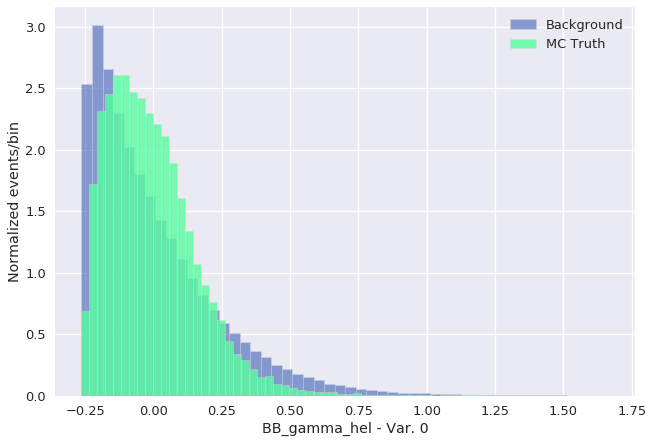

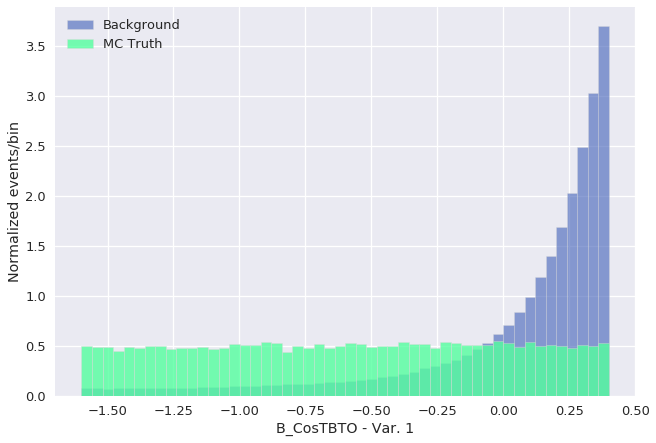

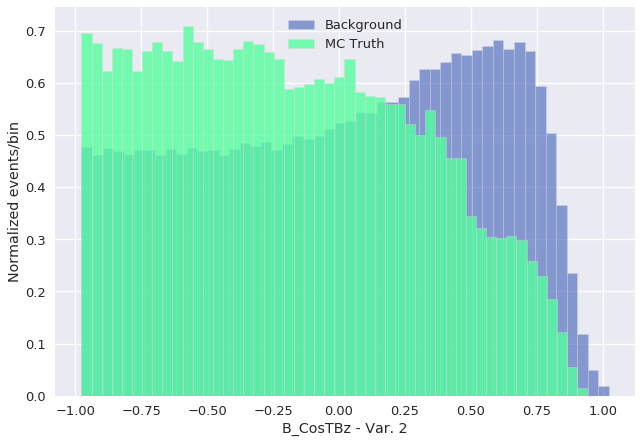

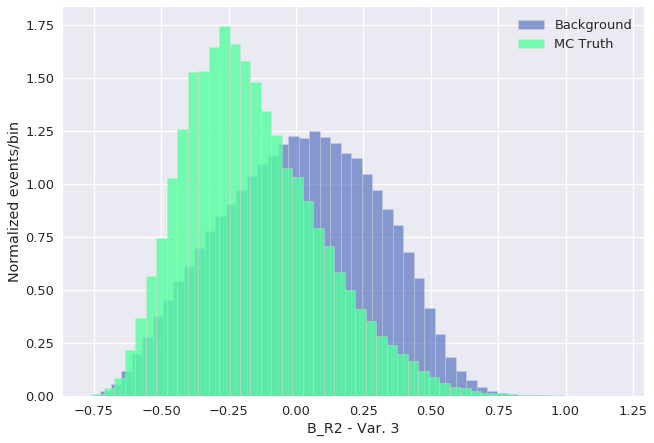

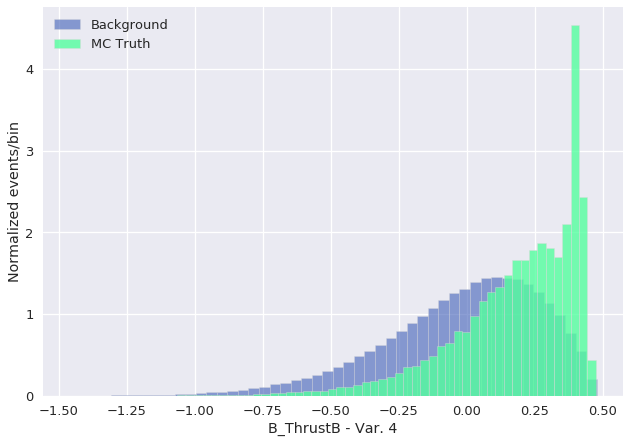

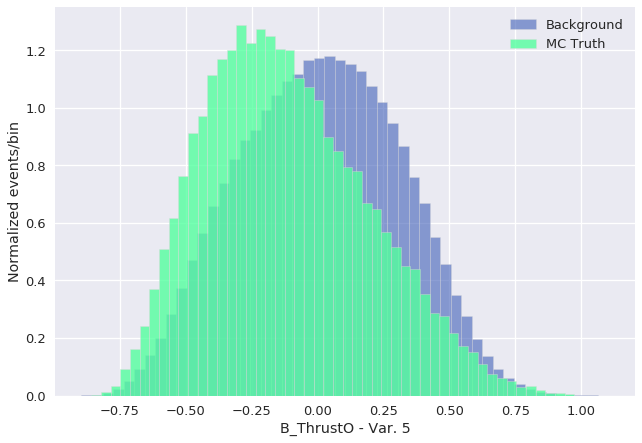

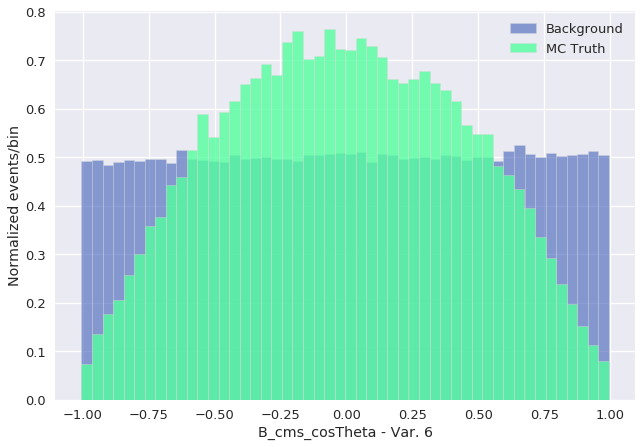

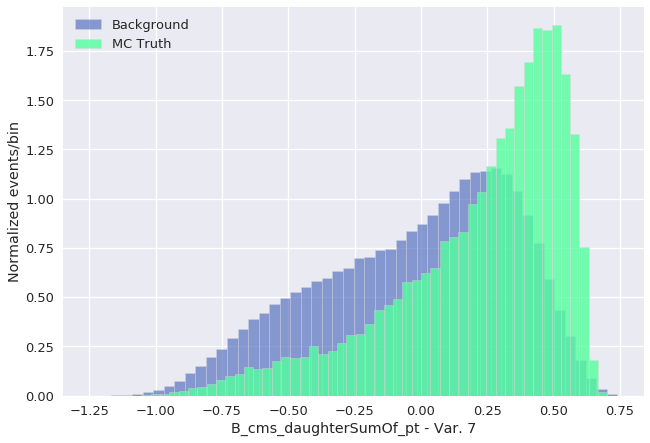

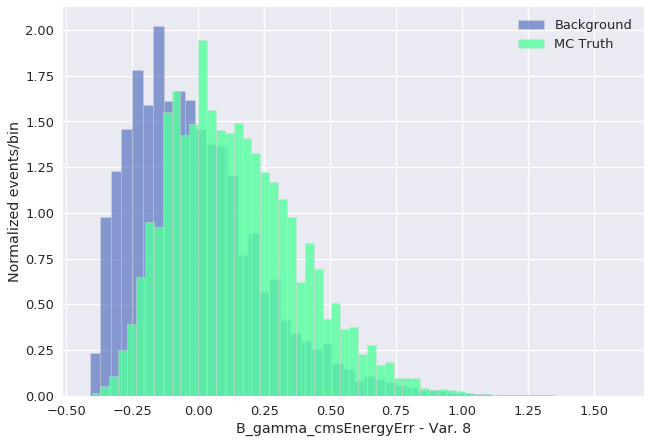

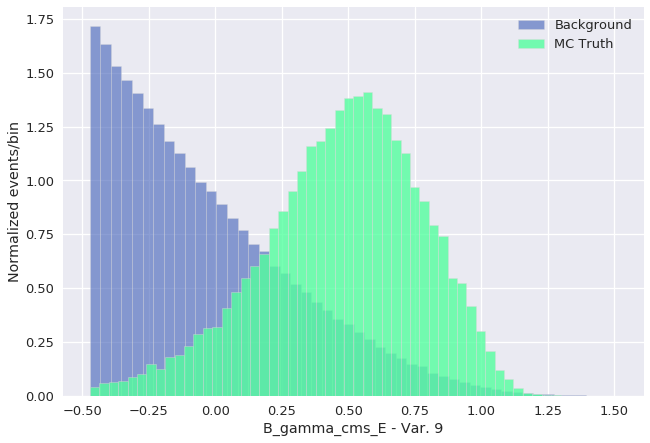

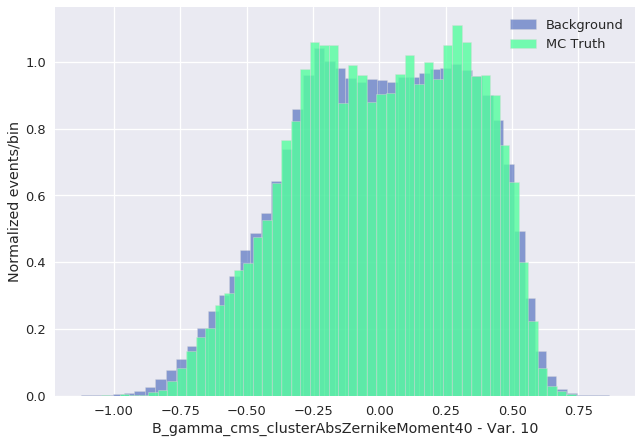

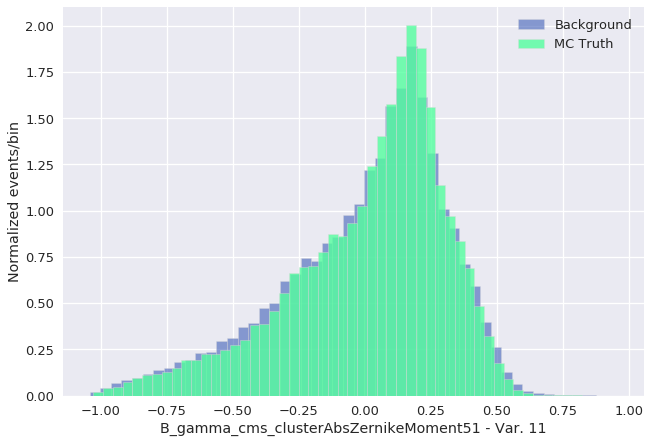

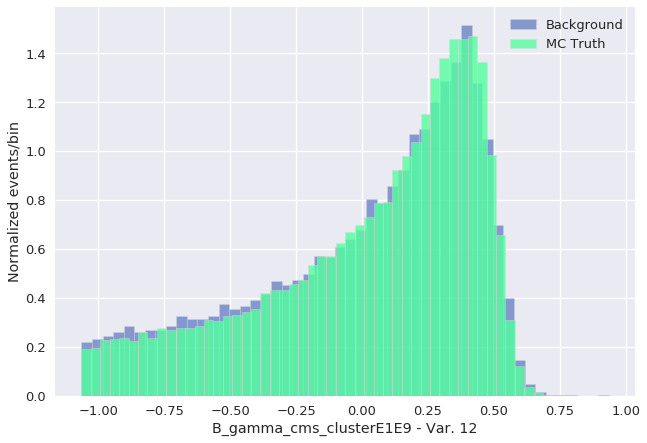

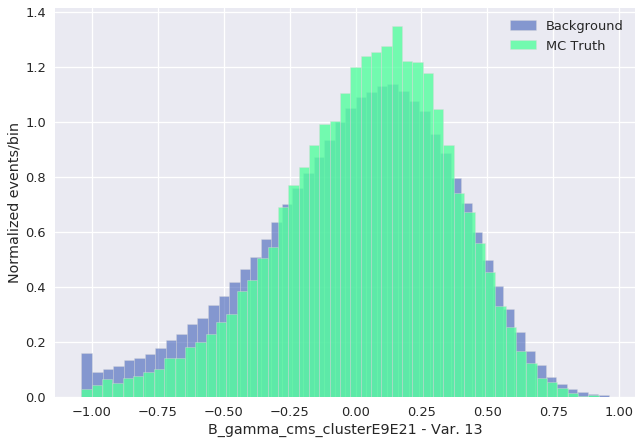

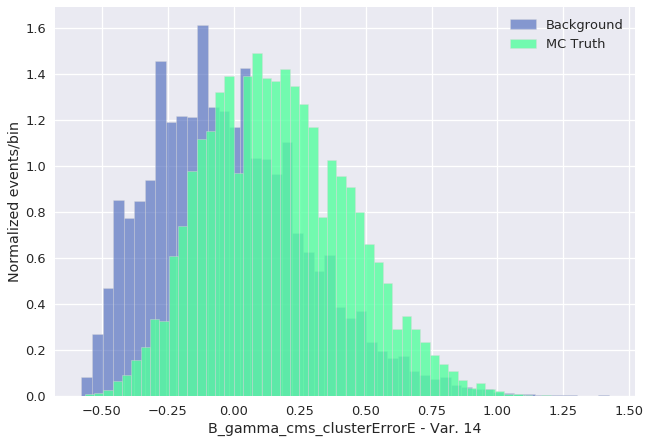

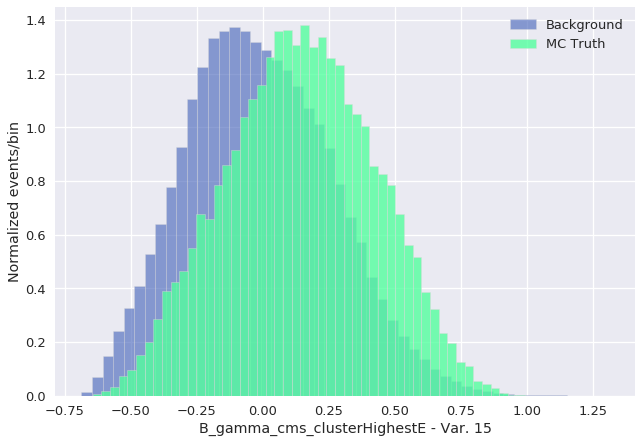

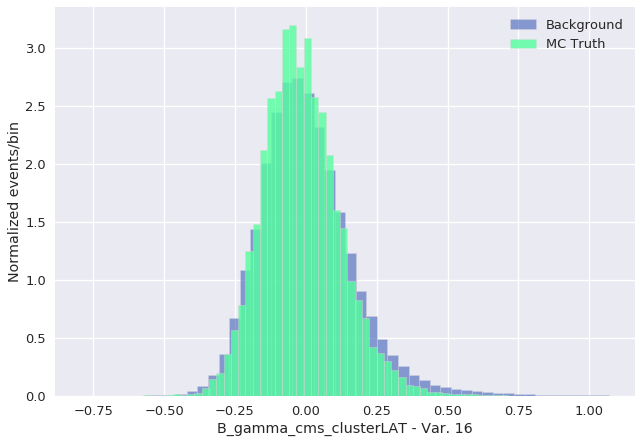

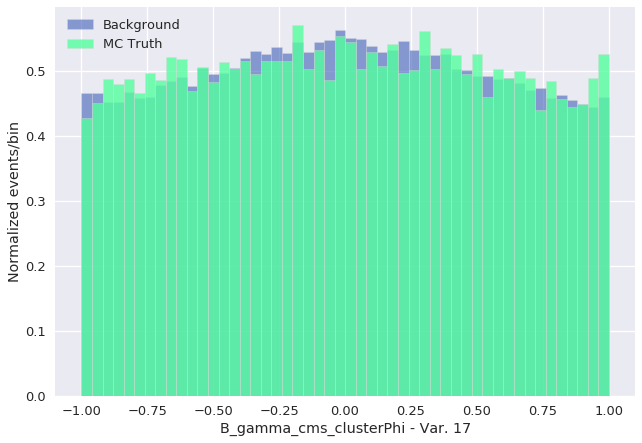

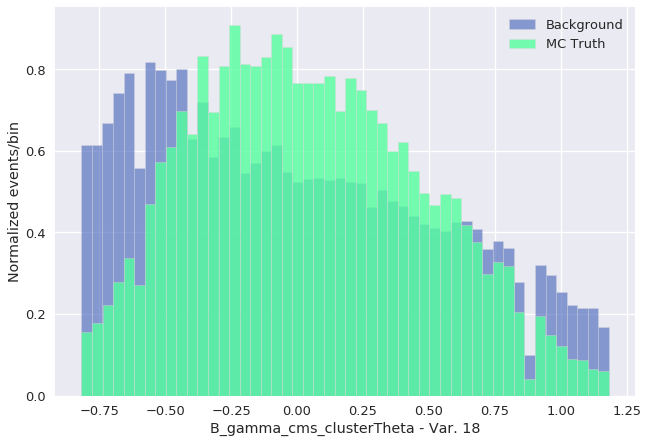

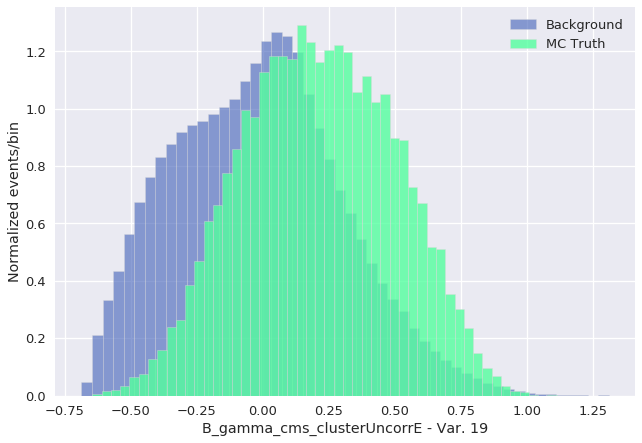

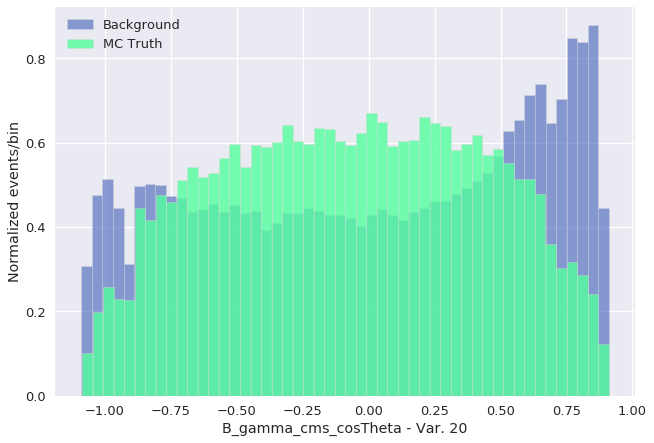

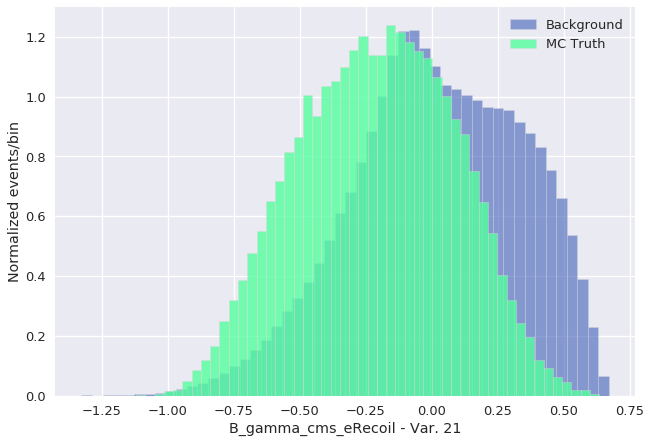

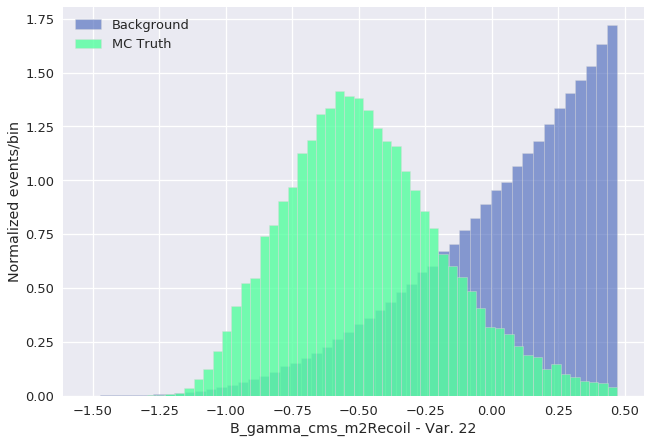

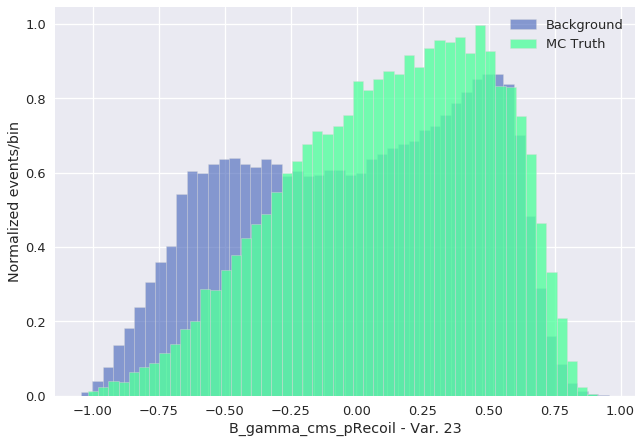

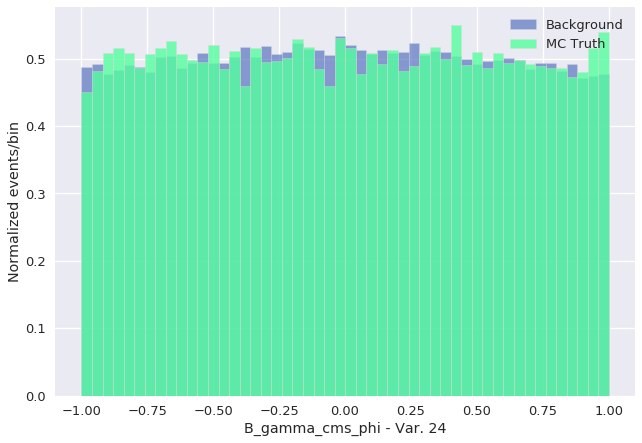

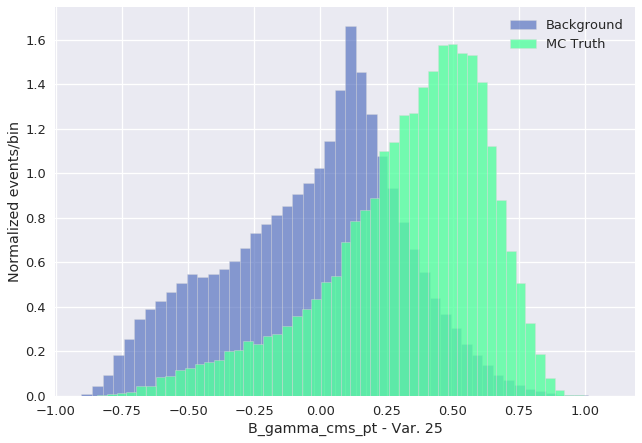

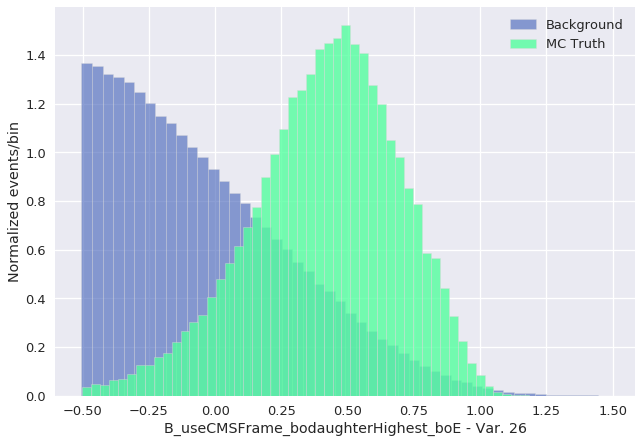

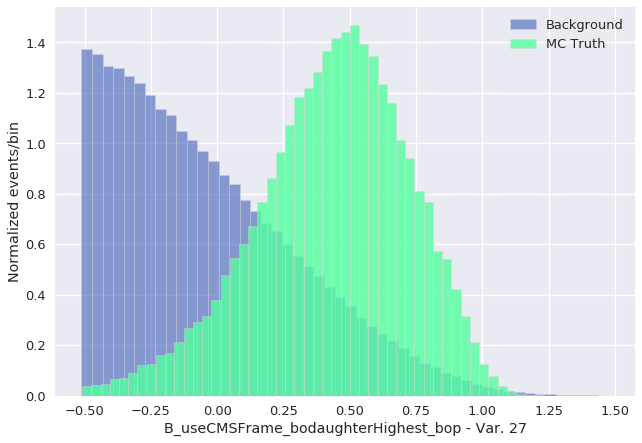

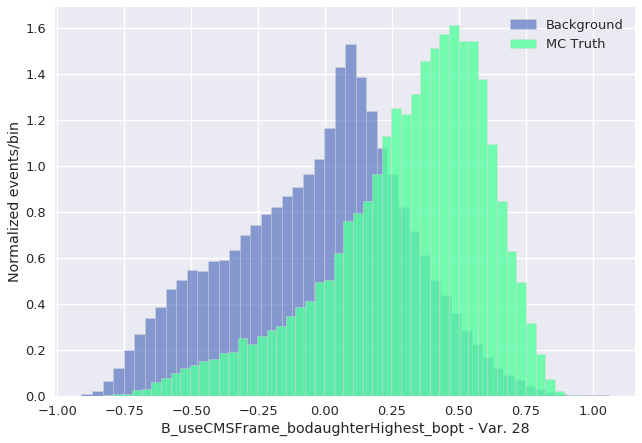

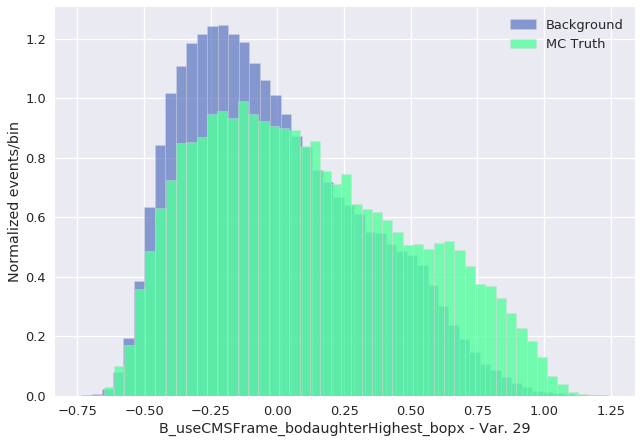

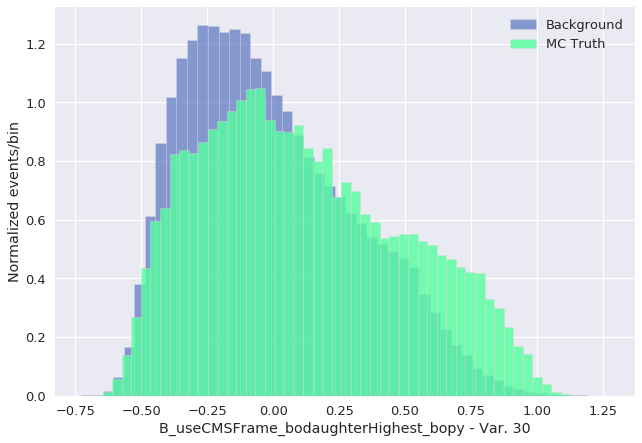

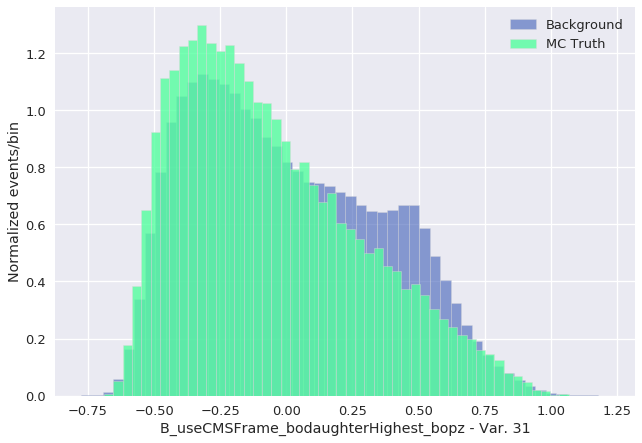

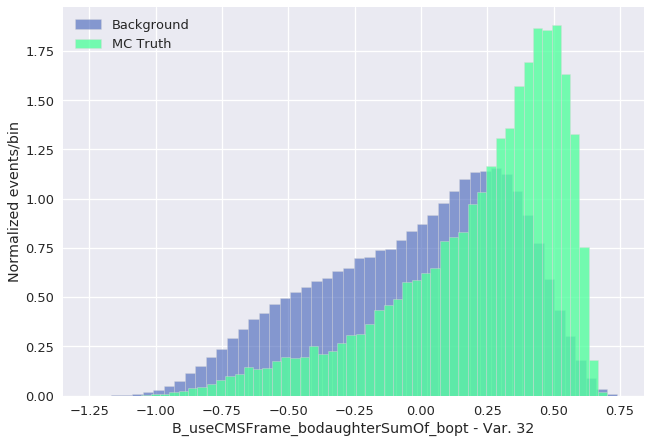

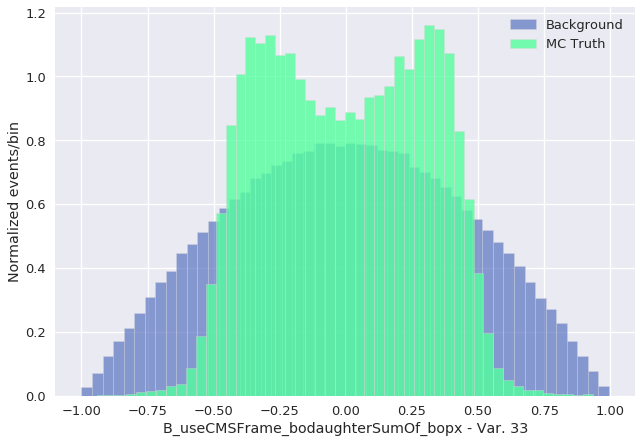

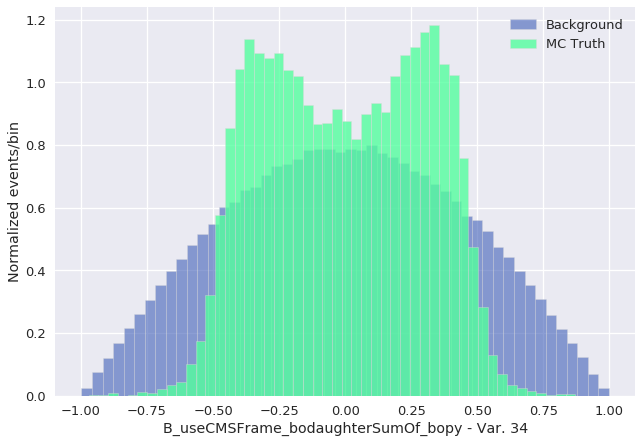

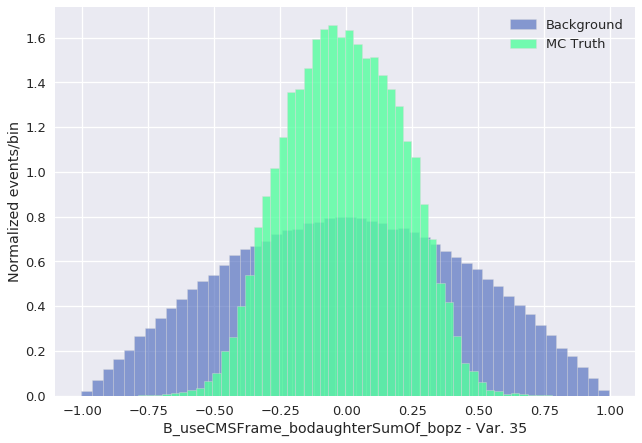

<Figure size 748.8x514.8 with 0 Axes>

In [38]:
# Data
nbins=50
variable = 'pivots'  # B_Mbc
df_bkg = data_df[data_df._label < 0.5]
df_sig = data_df[data_df._label > 0.5]
info_cols = [col for col in data_df.columns if not (col.endswith('_') and col.startswith('_')) and 'bodaughter' not in col]
compare_histograms_overlay(df_sig, df_bkg, nbins=nbins, columns=smooth_vars(), MC=True)

In [4]:
fname = '/home/jtan/gpu/jtan/data/vector/RAW_gamma_mc12_mc12_gamma.h5'
stream = pd.read_hdf(fname) #, iterator=True, chunksize=100000)
df = stream.sample(frac=1).reset_index(drop=True)

In [5]:
df_sig = df[df.label == 1]
df_B = df_sig[df_sig.isContinuumEvent == 0]
df_C = df_sig[df_sig.isContinuumEvent == 1]
parent_rad = lambda x: abs(x) in [30343, 30353, 323, 313]
df_rad_gamma = df_B[df_B['genMotherPDG__bo0__bc'].apply(parent_rad)]
df_rad_gamma = df_rad_gamma[df_rad_gamma['genMotherPDG__bo1__bc'].apply(parent_rad)]

Require (default cuts)
* CMS E between 1.8 and 3 GeV | Sig eff: 0.0642 | Bkg ret: 5e-4
* ClusterReg == 2 | Sig eff: 0.841 | Bkg ret: 0.510 (Exclude photon candidates in the endcaps)

All efficiencies hereafter relative to default
* E9E21 >= 0.95 | Sig eff: 0.983 | Bkg ret: 0.549 
* ClusterNHits >= 10 | Sig eff: 0.999 | Bkg ret: 0.929
* E9E1 < 0.9 | Sig eff: 0.993 | Bkg ret: 0.934
* ClusterReg == 2 | Sig eff: 0.841 | Bkg ret: 0.510 (Exclude photon candidates in the endcaps)
* ClusterSecondMoment < 1.5 | Sig eff: 0.977 | Bkg ret: 0.512

Now look at radiative signal photon from $b \rightarrow s \gamma$ process vs. correctly reconstructed photons incorrectly identified as the radiative photon.

Cut flow:


In [6]:
cuts = ['1.8 < useCMSFrame__boE__bc < 3.0', 'clusterReg == 2', 'clusterNHits > 10', 'clusterE1E9 < 0.95', 'clusterE9E21 > 0.95', 'clusterSecondMoment < 1.5']
all_cuts = " & ".join(cuts[:-1])
df_cut_1 = df.query(cuts[0])
df_cut_2 = df_cut_1.query(cuts[1])
df_cut_3 = df_cut_1.query(cuts[2])
df_cut_4 = df_cut_1.query(cuts[3])
df_cut_5 = df_cut_1.query(cuts[4])
df_cut_6 = df_cut_1.query(cuts[5])

In [7]:
def calculate_eff(df, df_cut):
    df_sig, df_bkg = df[df['label']>0.5], df[df['label']<0.5]
    df_sig_cut, df_bkg_cut = df_cut[df_cut['label']>0.5], df_cut[df_cut['label']<0.5]
    overall_eff = df_cut.shape[0]/df.shape[0]
    sig_eff = df_sig_cut.shape[0]/df_sig.shape[0]
    bkg_ret = df_bkg_cut.shape[0]/df_bkg.shape[0]
    
    print('Overall: {:.4f} | Sig eff: {:.4f} | Bkg ret: {:.4f}'.format(overall_eff, sig_eff, bkg_ret))
    
    return sig_eff, bkg_ret

In [8]:
df_cut_old = df
sig_eff_cum = 1
bkg_ret_cum = 1
for cut in cuts:
    print(cut)
    df_cut_new = df_cut_old.query(cut)
    sig_eff, bkg_ret = calculate_eff(df_cut_old, df_cut_new)
    sig_eff_cum *= sig_eff
    bkg_ret_cum *= bkg_ret
    print('Cum sig eff:{:.5f}, cum bkg ret:{:.5f}'.format(sig_eff_cum, bkg_ret_cum))
    df_cut_old = df_cut_new    

1.8 < useCMSFrame__boE__bc < 3.0
Overall: 0.0425 | Sig eff: 0.0639 | Bkg ret: 0.0005
Cum sig eff:0.06393, cum bkg ret:0.00050
clusterReg == 2
Overall: 0.8389 | Sig eff: 0.8402 | Bkg ret: 0.5003
Cum sig eff:0.05371, cum bkg ret:0.00025
clusterNHits > 10
Overall: 0.9996 | Sig eff: 0.9998 | Bkg ret: 0.8965
Cum sig eff:0.05370, cum bkg ret:0.00022
clusterE1E9 < 0.95
Overall: 1.0000 | Sig eff: 1.0000 | Bkg ret: 0.9988
Cum sig eff:0.05370, cum bkg ret:0.00022
clusterE9E21 > 0.95
Overall: 0.9885 | Sig eff: 0.9895 | Bkg ret: 0.5076
Cum sig eff:0.05314, cum bkg ret:0.00011
clusterSecondMoment < 1.5
Overall: 0.9942 | Sig eff: 0.9943 | Bkg ret: 0.8678
Cum sig eff:0.05284, cum bkg ret:0.00010


In [15]:
calculate_eff(df_cut_1, df_cut_6)

Overall: 0.9751 | Sig eff: 0.9769 | Bkg ret: 0.5294


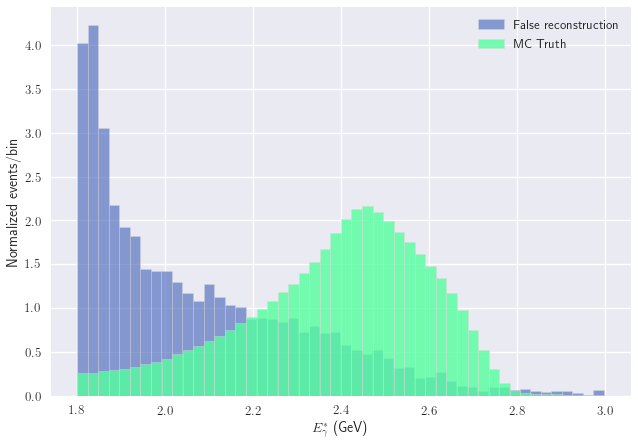

<Figure size 748.8x514.8 with 0 Axes>

In [85]:
rc('text', usetex=True)
compare_histograms_overlay(df_sig, df_bkg, nbins=nbins, columns=['useCMSFrame__boE__bc'], xlabel=r'$E_{\gamma}^*$ (GeV)', save=True)
rc('text', usetex=False)

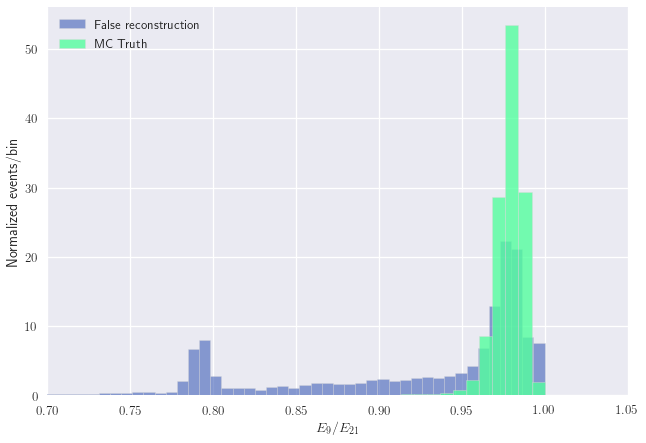

<Figure size 748.8x514.8 with 0 Axes>

In [49]:
rc('text', usetex=True)
compare_histograms_overlay(df_sig, df_bkg, nbins=60, columns=['clusterE9E21'], xlabel=r'$E_9/E_{21}$', save=True, xlim=(0.7,1.05))
rc('text', usetex=False)

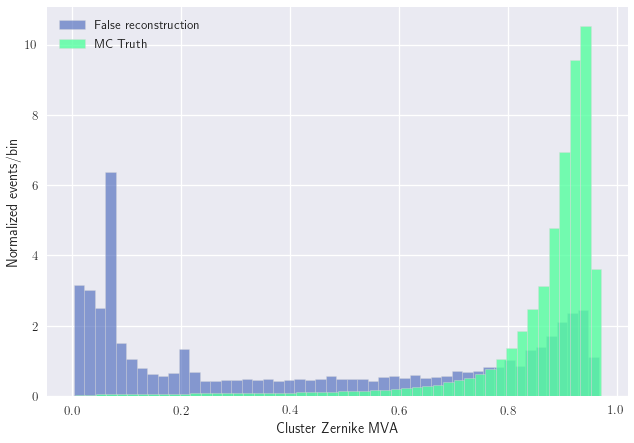

<Figure size 748.8x514.8 with 0 Axes>

In [98]:
rc('text', usetex=True)
compare_histograms_overlay(df_sig, df_bkg, nbins=nbins, columns=['clusterZernikeMVA'], xlabel=r'Cluster Zernike MVA', save=True)#, xlim=(0.7,1.05))
rc('text', usetex=False)

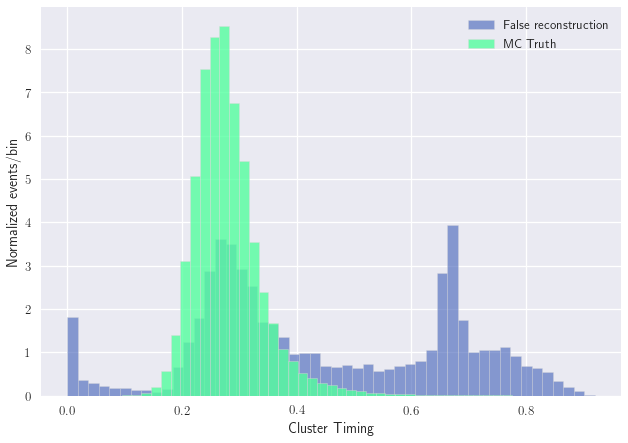

<Figure size 748.8x514.8 with 0 Axes>

In [99]:
rc('text', usetex=True)
compare_histograms_overlay(df_sig, df_bkg, nbins=nbins, columns=['clusterLAT'], xlabel=r'Cluster Timing', save=True)#, xlim=(0.7,1.05))
rc('text', usetex=False)

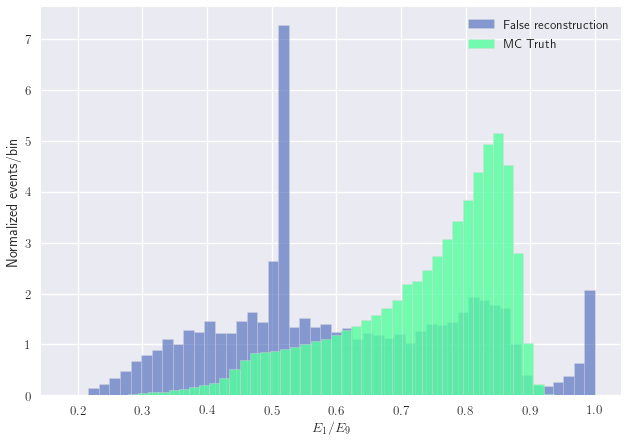

<Figure size 748.8x514.8 with 0 Axes>

In [50]:
rc('text', usetex=True)
compare_histograms_overlay(df_sig, df_bkg, nbins=nbins, columns=['clusterE1E9'], xlabel=r'$E_1/E_9$', save=True)#, xlim=(0.7,1.05))
rc('text', usetex=False)

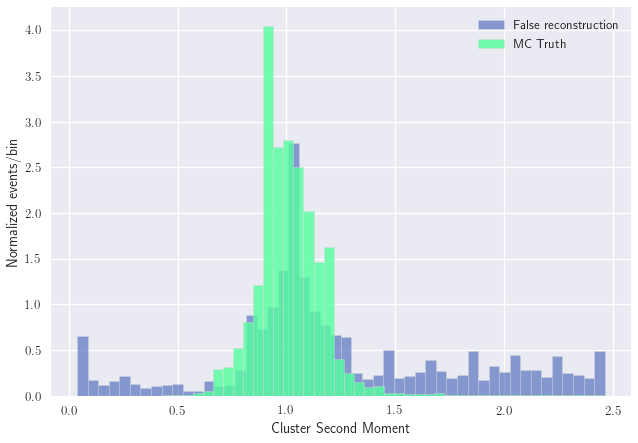

<Figure size 748.8x514.8 with 0 Axes>

In [81]:
df_sig_sm, df_bkg_sm = df_cut_5[df_cut_5['label']>0.5], df_cut_5[df_cut_5['label']<0.5]
df_sig_sm = df_sig_sm.query('0. < clusterSecondMoment < 2.5')
df_bkg_sm = df_bkg_sm.query('0. < clusterSecondMoment < 2.5')

rc('text', usetex=True)
compare_histograms_overlay(df_sig_sm, df_bkg_sm, nbins=nbins, columns=['clusterSecondMoment'], xlabel='Cluster Second Moment', save=True, xlim=(0.,2.5))
rc('text', usetex=False)

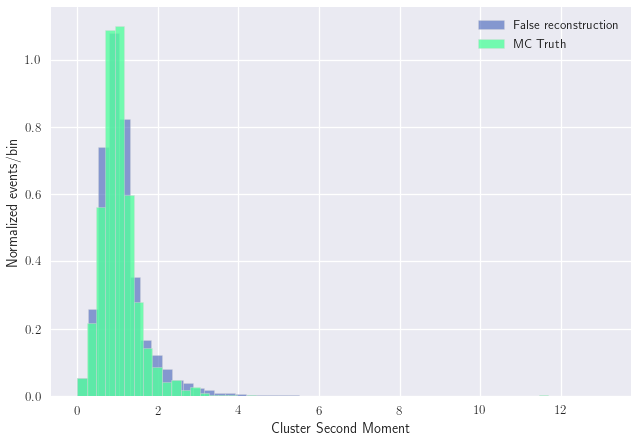

<Figure size 748.8x514.8 with 0 Axes>

In [19]:
rc('text', usetex=True)
compare_histograms_overlay(df_rad_gamma, df_C, nbins=nbins, columns=['clusterSecondMoment'], xlabel='Cluster Second Moment', save=True)#, xlim=(0.7,1.05))
rc('text', usetex=False)

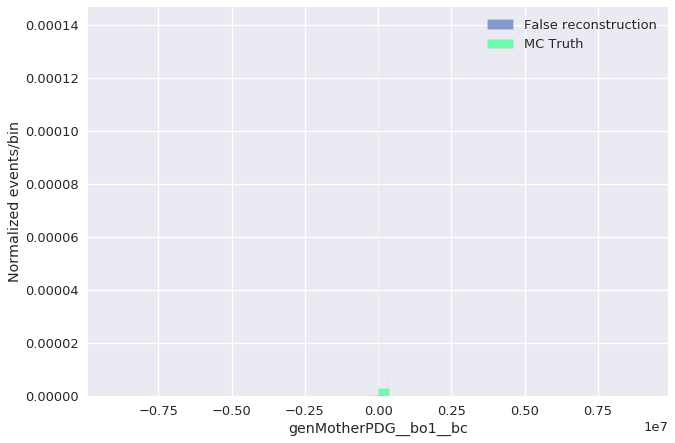

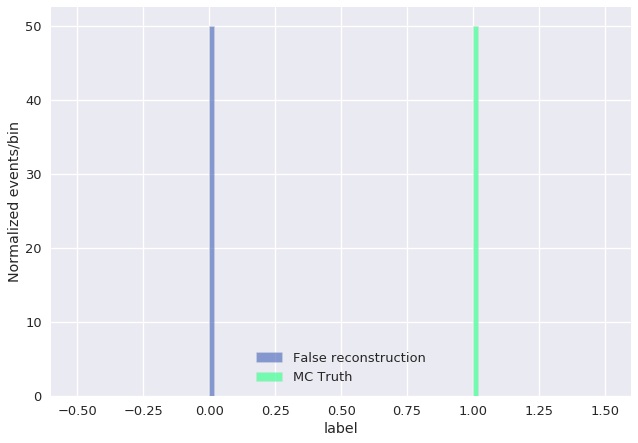

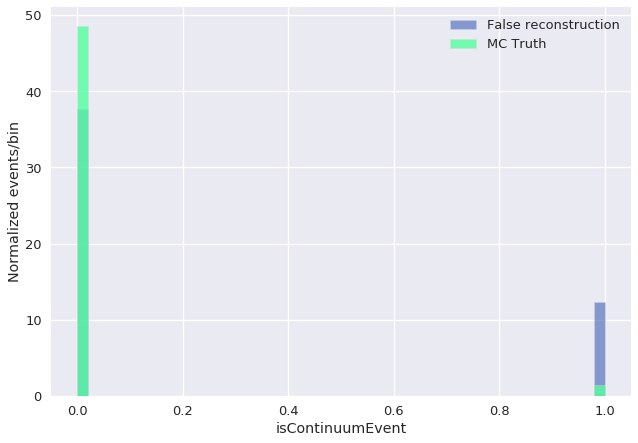

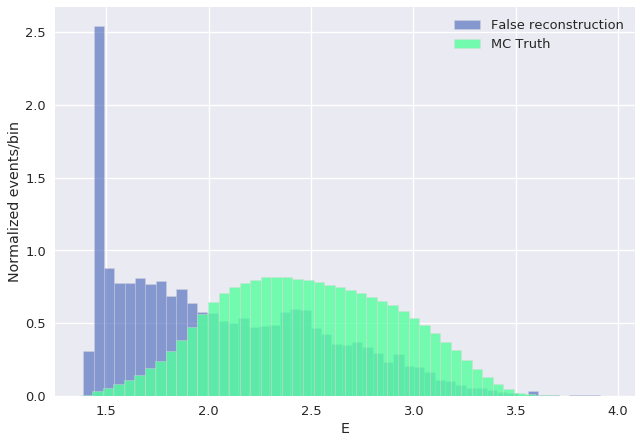

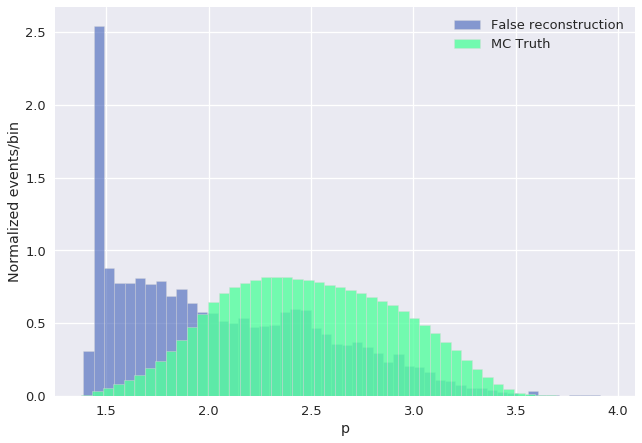

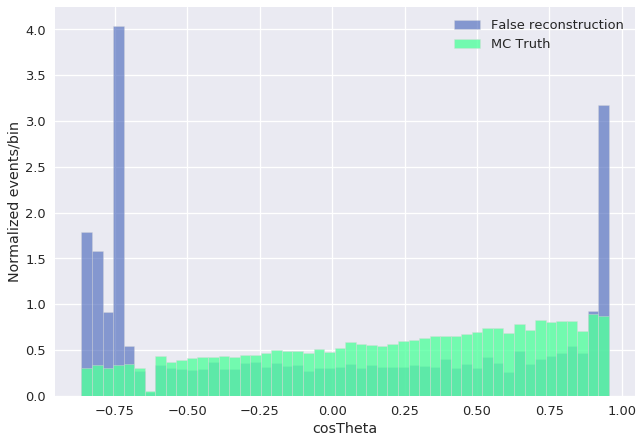

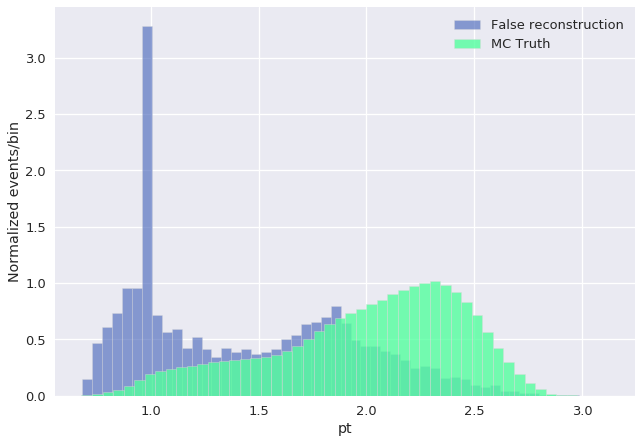

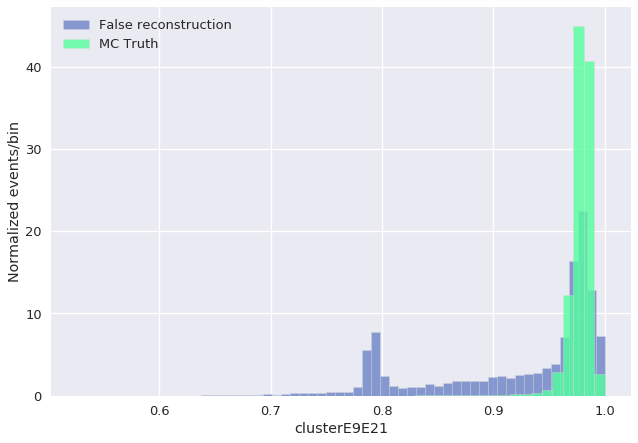

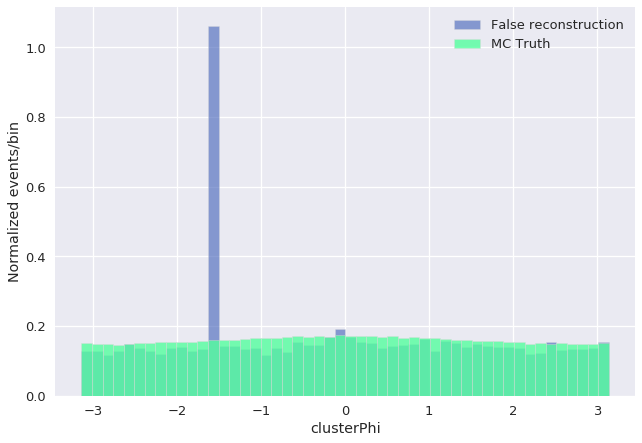

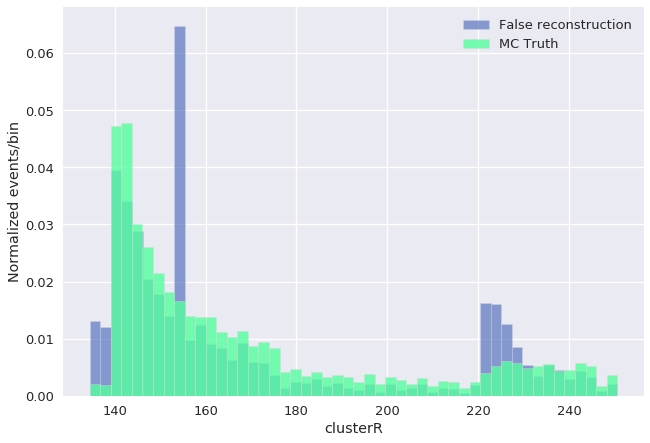

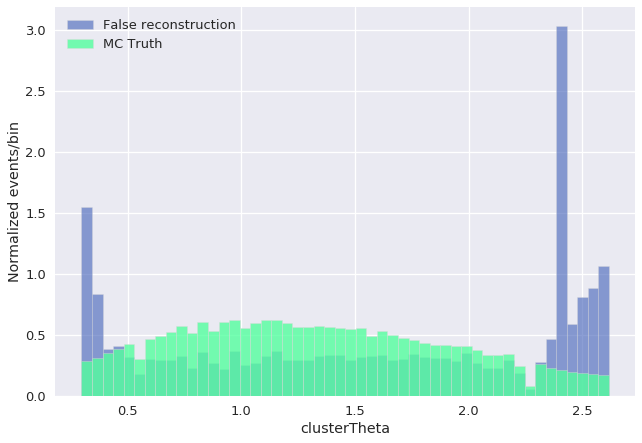

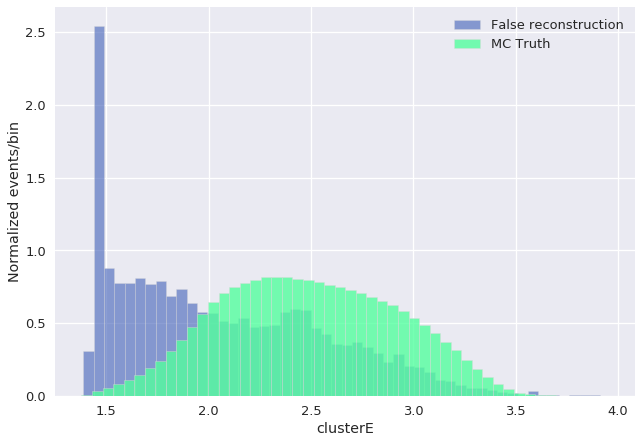

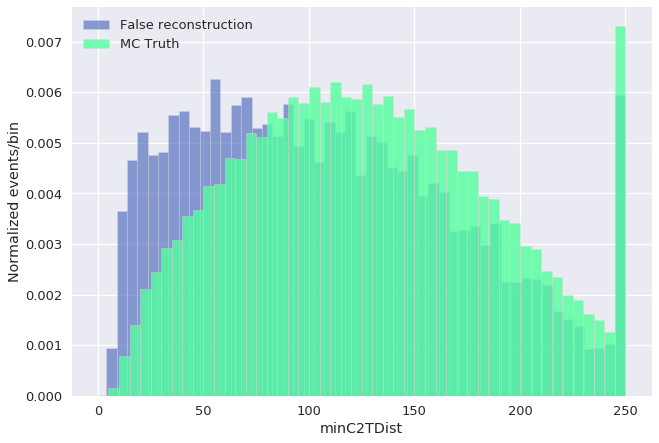

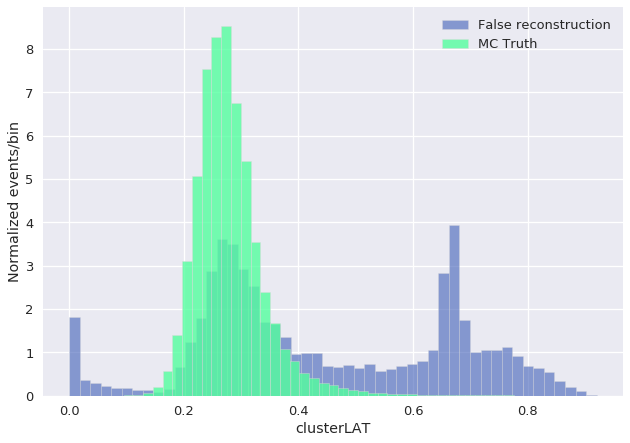

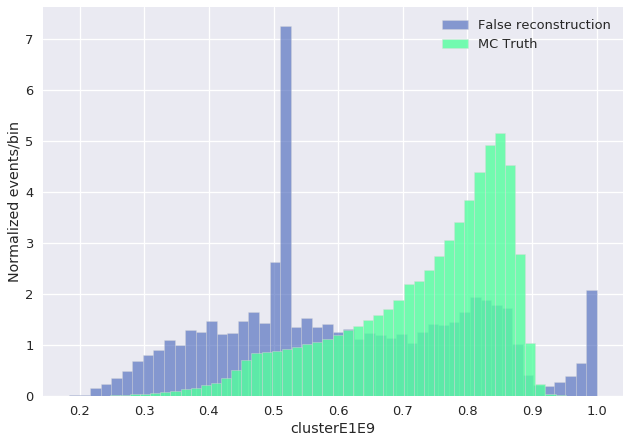

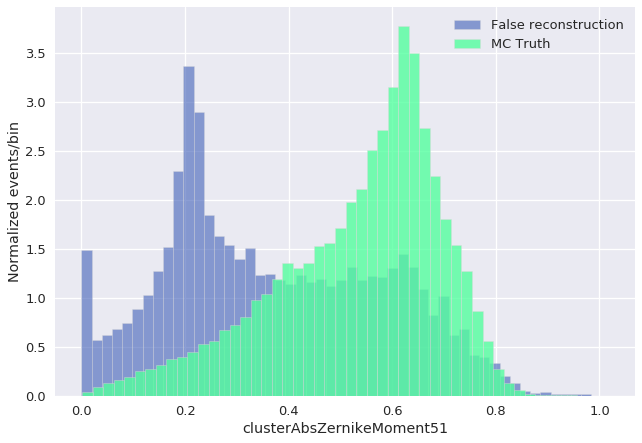

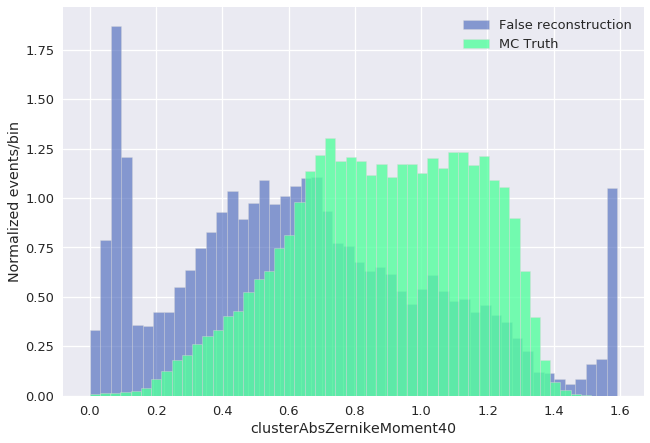

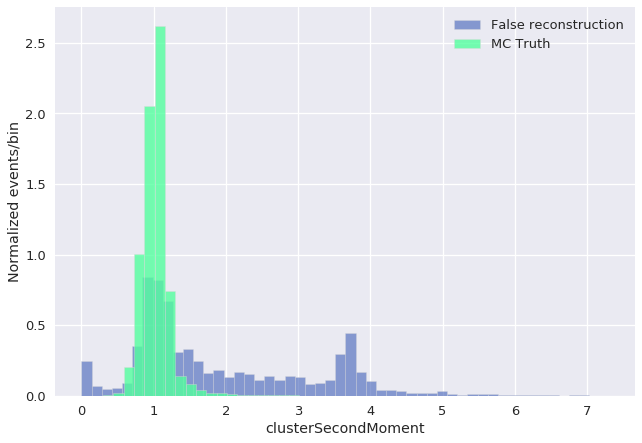

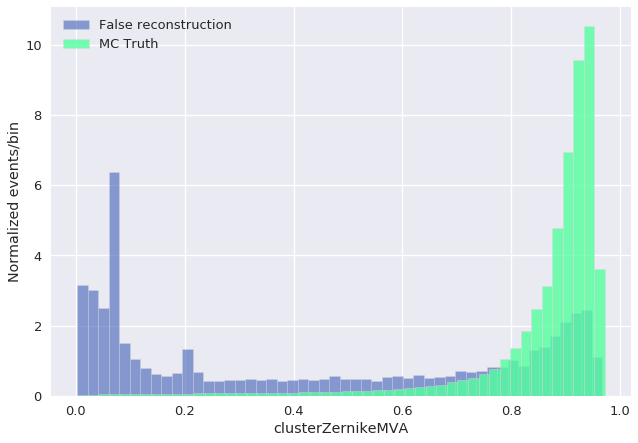

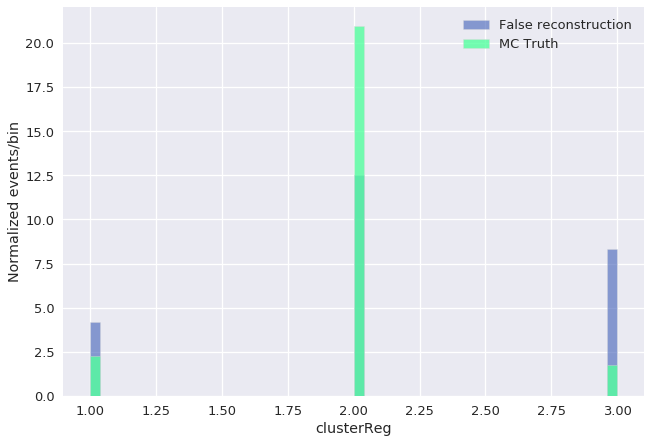

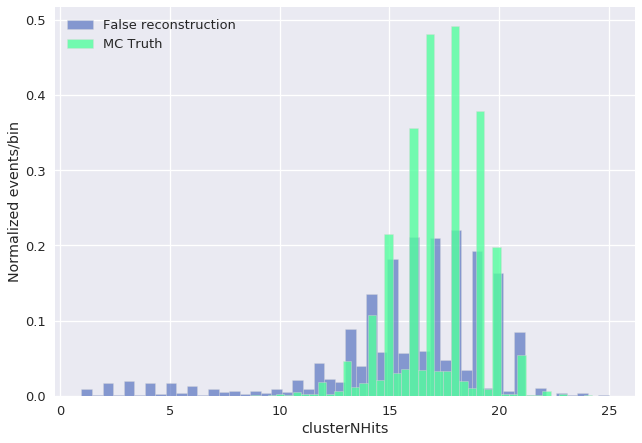

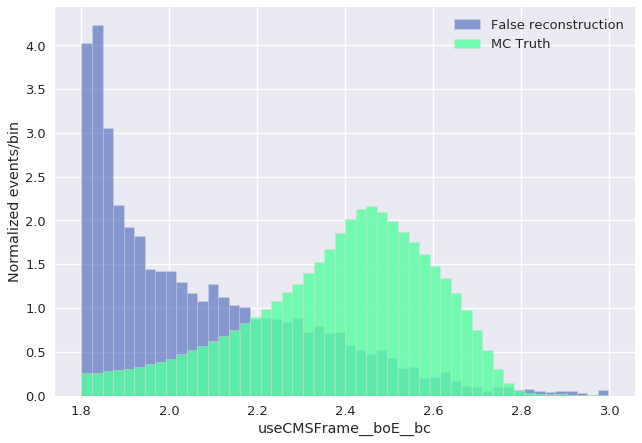

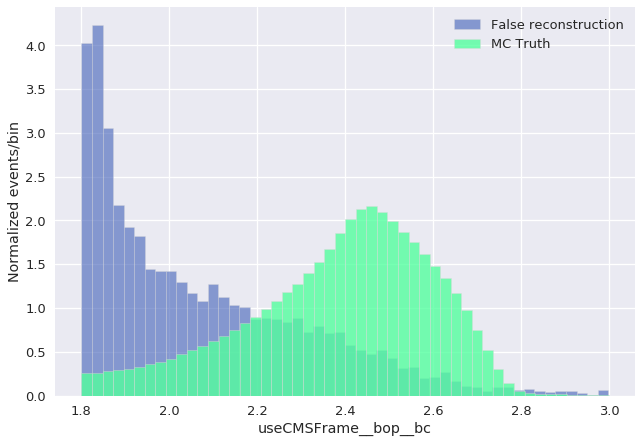

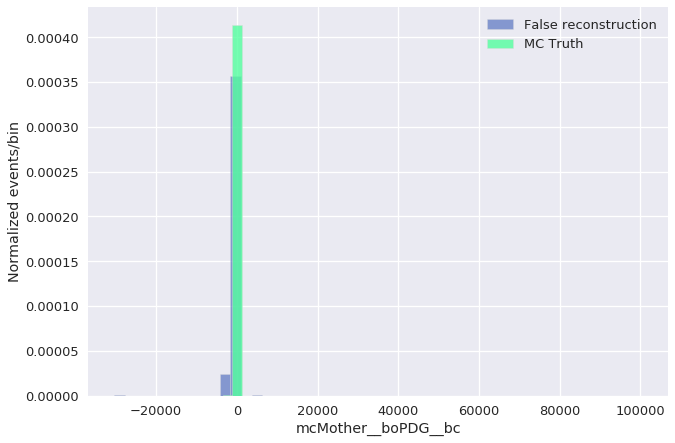

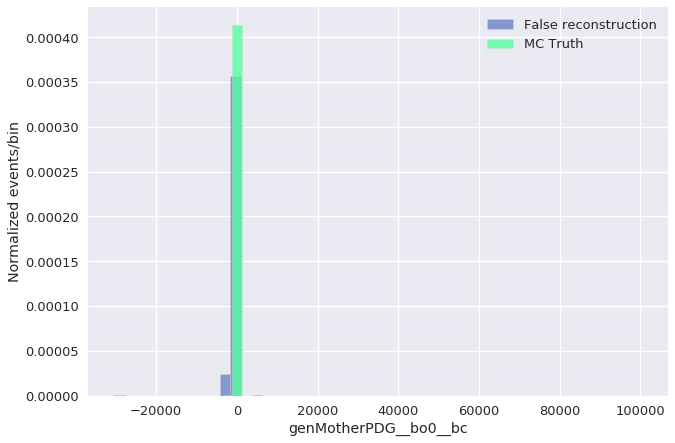

<Figure size 748.8x514.8 with 0 Axes>

In [97]:
# MC
rc('text', usetex=False)
# df_sig, df_bkg = df[df['label']>0.5], df[df['label']<0.5]
df_sig, df_bkg = df_cut_1[df_cut_1['label']>0.5], df_cut_1[df_cut_1['label']<0.5]
nbins=50
variable = 'pivots'  # B_Mbc
info_cols = [col for col in df.columns if not (col.endswith('_') and col.startswith('_')) and 'bodaughter' not in col]
compare_histograms_overlay(df_sig, df_bkg, nbins=nbins, columns=info_cols)

/home/jtan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


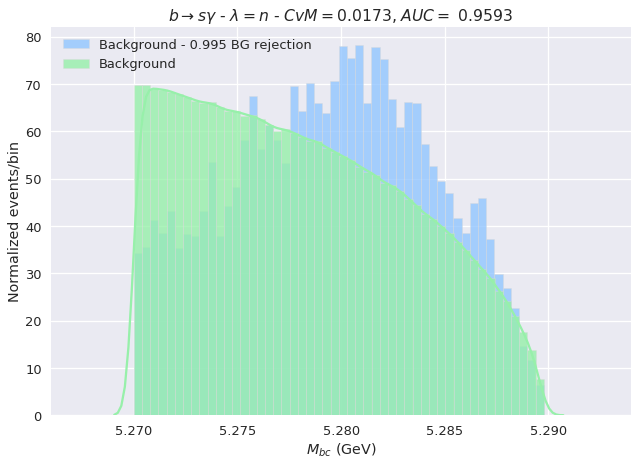

In [48]:
sns.distplot(select, hist=True, kde=False, norm_hist=True, label = r'Background - 0.995 BG rejection',bins=nbins,
     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8))
sns.distplot(original, hist=True, kde=True, norm_hist=True, label = r'Background',bins=nbins,
     hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha = 0.8))

plt.xlim((5.266,5.294))
plt.xlabel(r'$M_{bc}$ (GeV)')
plt.ylabel(r'Normalized events/bin')
plt.legend(loc="best")
title = r'$\lambda = n$'
plt.title(r'$b\rightarrow s \gamma$ - {} - $CvM = ${:.4f}, $AUC = $ {:.4f}'.format(title, cvm, roc_auc))
plt.savefig(os.path.join('results', 'mbc_dense_test.pdf'), format='pdf', dpi=1000, bbox_inches='tight')